# Stratified Sampling in Data Mining

## Learning Objectives
By the end of this notebook, you will understand:
- The concept and importance of stratified sampling
- How stratified sampling differs from simple random sampling
- When and why to use stratified sampling techniques
- How to implement stratified sampling using scikit-learn
- How to validate that stratified samples maintain proportional representation
- Real-world applications of stratified sampling in data mining

## Introduction
Stratified sampling is a probability sampling technique where the population is divided into homogeneous subgroups (strata) and samples are drawn from each stratum. This method ensures that each subgroup is proportionally represented in the sample, making it particularly valuable when:

- **Population has distinct subgroups** (e.g., age groups, income levels, geographic regions)
- **Subgroups have different characteristics** that are important for analysis
- **You need guaranteed representation** of minority groups
- **Reducing sampling variance** is important for statistical inference

Unlike simple random sampling, stratified sampling guarantees that important subgroups won't be accidentally under-represented or over-represented in your sample.

In [1]:
# Import Required Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully!
NumPy version: 1.26.4
Pandas version: 2.3.1


## Step 1: Create Heterogeneous Dataset

Let's create a customer dataset with distinct segments to demonstrate the importance of stratified sampling.

In [2]:
# Sample data: Customer segments, incomes, and spending scores
np.random.seed(42)  # For reproducible results

# Create realistic customer segments with different characteristics
segments = []
incomes = []
spending_scores = []
customer_ids = np.arange(1, 101)

# Youth segment (30%): Lower income, higher spending scores
youth_count = 30
segments.extend(["Youth"] * youth_count)
incomes.extend(np.random.normal(35000, 8000, youth_count).astype(int))
spending_scores.extend(np.random.normal(75, 15, youth_count).astype(int))

# Adult segment (50%): Higher income, moderate spending scores  
adult_count = 50
segments.extend(["Adult"] * adult_count)
incomes.extend(np.random.normal(65000, 15000, adult_count).astype(int))
spending_scores.extend(np.random.normal(55, 20, adult_count).astype(int))

# Senior segment (20%): Moderate income, lower spending scores
senior_count = 20
segments.extend(["Senior"] * senior_count)
incomes.extend(np.random.normal(45000, 12000, senior_count).astype(int))
spending_scores.extend(np.random.normal(35, 12, senior_count).astype(int))

# Ensure values are within realistic ranges
incomes = np.clip(incomes, 20000, 120000)
spending_scores = np.clip(spending_scores, 1, 100)

# Create DataFrame
data = {
    "Customer_ID": customer_ids,
    "Segment": segments,
    "Income": incomes,
    "Spending_Score": spending_scores
}

df = pd.DataFrame(data)
print("Dataset created successfully!")
print(f"Total customers: {len(df)}")
print(f"\nOriginal Data Distribution:")
print(df["Segment"].value_counts())
print(f"\nPercentage Distribution:")
print((df["Segment"].value_counts() / len(df) * 100).round(1))

Dataset created successfully!
Total customers: 100

Original Data Distribution:
Segment
Adult     50
Youth     30
Senior    20
Name: count, dtype: int64

Percentage Distribution:
Segment
Adult     50.0
Youth     30.0
Senior    20.0
Name: count, dtype: float64


## Step 2: Analyze Segment Characteristics

Let's examine how different segments have distinct characteristics, which justifies the need for stratified sampling.

Segment Characteristics Analysis:
         Count  Income_Mean  Income_Std  Score_Mean  Score_Std
Segment                                                       
Adult       50     64519.52    13439.62       54.42      20.20
Senior      20     49098.10    12055.23       32.00       8.79
Youth       30     33504.50     7179.96       72.60      13.79


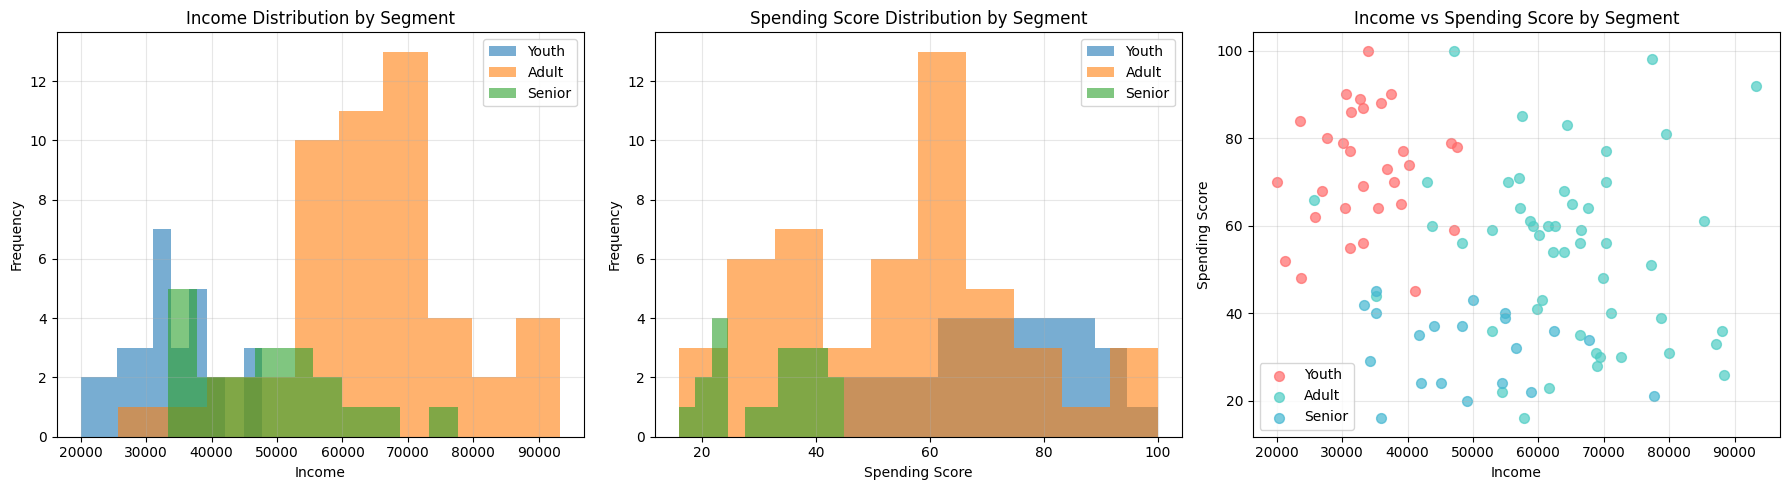

In [3]:
# Analyze characteristics by segment
print("Segment Characteristics Analysis:")
print("=" * 50)

segment_stats = df.groupby('Segment').agg({
    'Income': ['count', 'mean', 'std'],
    'Spending_Score': ['mean', 'std']
}).round(2)

segment_stats.columns = ['Count', 'Income_Mean', 'Income_Std', 'Score_Mean', 'Score_Std']
print(segment_stats)

# Create visualization showing segment differences
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Income distribution by segment
for segment in df['Segment'].unique():
    segment_data = df[df['Segment'] == segment]
    axes[0].hist(segment_data['Income'], alpha=0.6, label=segment, bins=10)
axes[0].set_xlabel('Income')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Income Distribution by Segment')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Spending Score distribution by segment
for segment in df['Segment'].unique():
    segment_data = df[df['Segment'] == segment]
    axes[1].hist(segment_data['Spending_Score'], alpha=0.6, label=segment, bins=10)
axes[1].set_xlabel('Spending Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Spending Score Distribution by Segment')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Scatter plot showing relationship
colors = {'Youth': '#FF6B6B', 'Adult': '#4ECDC4', 'Senior': '#45B7D1'}
for segment in df['Segment'].unique():
    segment_data = df[df['Segment'] == segment]
    axes[2].scatter(segment_data['Income'], segment_data['Spending_Score'], 
                   label=segment, alpha=0.7, color=colors[segment], s=50)
axes[2].set_xlabel('Income')
axes[2].set_ylabel('Spending Score')
axes[2].set_title('Income vs Spending Score by Segment')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 3: Simple Random Sampling (for comparison)

First, let's see what happens with simple random sampling - it might not preserve the segment proportions.

In [4]:
# Simple random sampling (20% of data)
sample_size = int(0.2 * len(df))
random_sample = df.sample(n=sample_size, random_state=42)

print("Simple Random Sampling Results:")
print(f"Sample size: {len(random_sample)} ({len(random_sample)/len(df)*100:.1f}%)")
print(f"\nOriginal distribution:")
original_dist = df["Segment"].value_counts()
print(original_dist)
print(f"\nOriginal percentages:")
print((original_dist / len(df) * 100).round(1))

print(f"\nRandom sample distribution:")
random_dist = random_sample["Segment"].value_counts()
print(random_dist)
print(f"\nRandom sample percentages:")
print((random_dist / len(random_sample) * 100).round(1))

# Calculate representation differences
print(f"\nRepresentation Differences (Random Sampling):")
for segment in df['Segment'].unique():
    original_pct = (df['Segment'] == segment).sum() / len(df) * 100
    sample_pct = (random_sample['Segment'] == segment).sum() / len(random_sample) * 100
    difference = abs(original_pct - sample_pct)
    print(f"{segment}: Original {original_pct:.1f}%, Sample {sample_pct:.1f}%, Diff: {difference:.1f}%")

Simple Random Sampling Results:
Sample size: 20 (20.0%)

Original distribution:
Segment
Adult     50
Youth     30
Senior    20
Name: count, dtype: int64

Original percentages:
Segment
Adult     50.0
Youth     30.0
Senior    20.0
Name: count, dtype: float64

Random sample distribution:
Segment
Adult     11
Youth      6
Senior     3
Name: count, dtype: int64

Random sample percentages:
Segment
Adult     55.0
Youth     30.0
Senior    15.0
Name: count, dtype: float64

Representation Differences (Random Sampling):
Youth: Original 30.0%, Sample 30.0%, Diff: 0.0%
Adult: Original 50.0%, Sample 55.0%, Diff: 5.0%
Senior: Original 20.0%, Sample 15.0%, Diff: 5.0%


## Step 4: Stratified Sampling Implementation

Now let's implement stratified sampling to maintain the exact proportional representation of each segment.

In [5]:
# Stratified Sampling: Maintain the same distribution of "Segment" in the sample
stratified_sample, _ = train_test_split(
    df, test_size=0.8, stratify=df["Segment"], random_state=42
)

print("Stratified Sampling Results:")
print(f"Sample size: {len(stratified_sample)} ({len(stratified_sample)/len(df)*100:.1f}%)")
print(f"\nStratified Sample:")
print(stratified_sample.head(10))

print(f"\nDistribution of Segments in Stratified Sample:")
stratified_dist = stratified_sample["Segment"].value_counts()
print(stratified_dist)
print(f"\nStratified sample percentages:")
print((stratified_dist / len(stratified_sample) * 100).round(1))

# Calculate representation differences for stratified sampling
print(f"\nRepresentation Differences (Stratified Sampling):")
for segment in df['Segment'].unique():
    original_pct = (df['Segment'] == segment).sum() / len(df) * 100
    sample_pct = (stratified_sample['Segment'] == segment).sum() / len(stratified_sample) * 100
    difference = abs(original_pct - sample_pct)
    print(f"{segment}: Original {original_pct:.1f}%, Sample {sample_pct:.1f}%, Diff: {difference:.1f}%")

Stratified Sampling Results:
Sample size: 20 (20.0%)

Stratified Sample:
    Customer_ID Segment  Income  Spending_Score
19           20   Youth   23701              48
84           85  Senior   56560              32
78           79   Adult   68863              31
69           70   Adult   61481              60
24           25   Youth   30644              90
29           30   Youth   32666              89
99          100  Senior   77642              21
75           76   Adult   71060              40
62           63   Adult   54469              22
95           96  Senior   54926              39

Distribution of Segments in Stratified Sample:
Segment
Adult     10
Youth      6
Senior     4
Name: count, dtype: int64

Stratified sample percentages:
Segment
Adult     50.0
Youth     30.0
Senior    20.0
Name: count, dtype: float64

Representation Differences (Stratified Sampling):
Youth: Original 30.0%, Sample 30.0%, Diff: 0.0%
Adult: Original 50.0%, Sample 50.0%, Diff: 0.0%
Senior: Original 2

## Step 5: Comparison Visualization

Let's visualize the differences between random sampling and stratified sampling approaches.

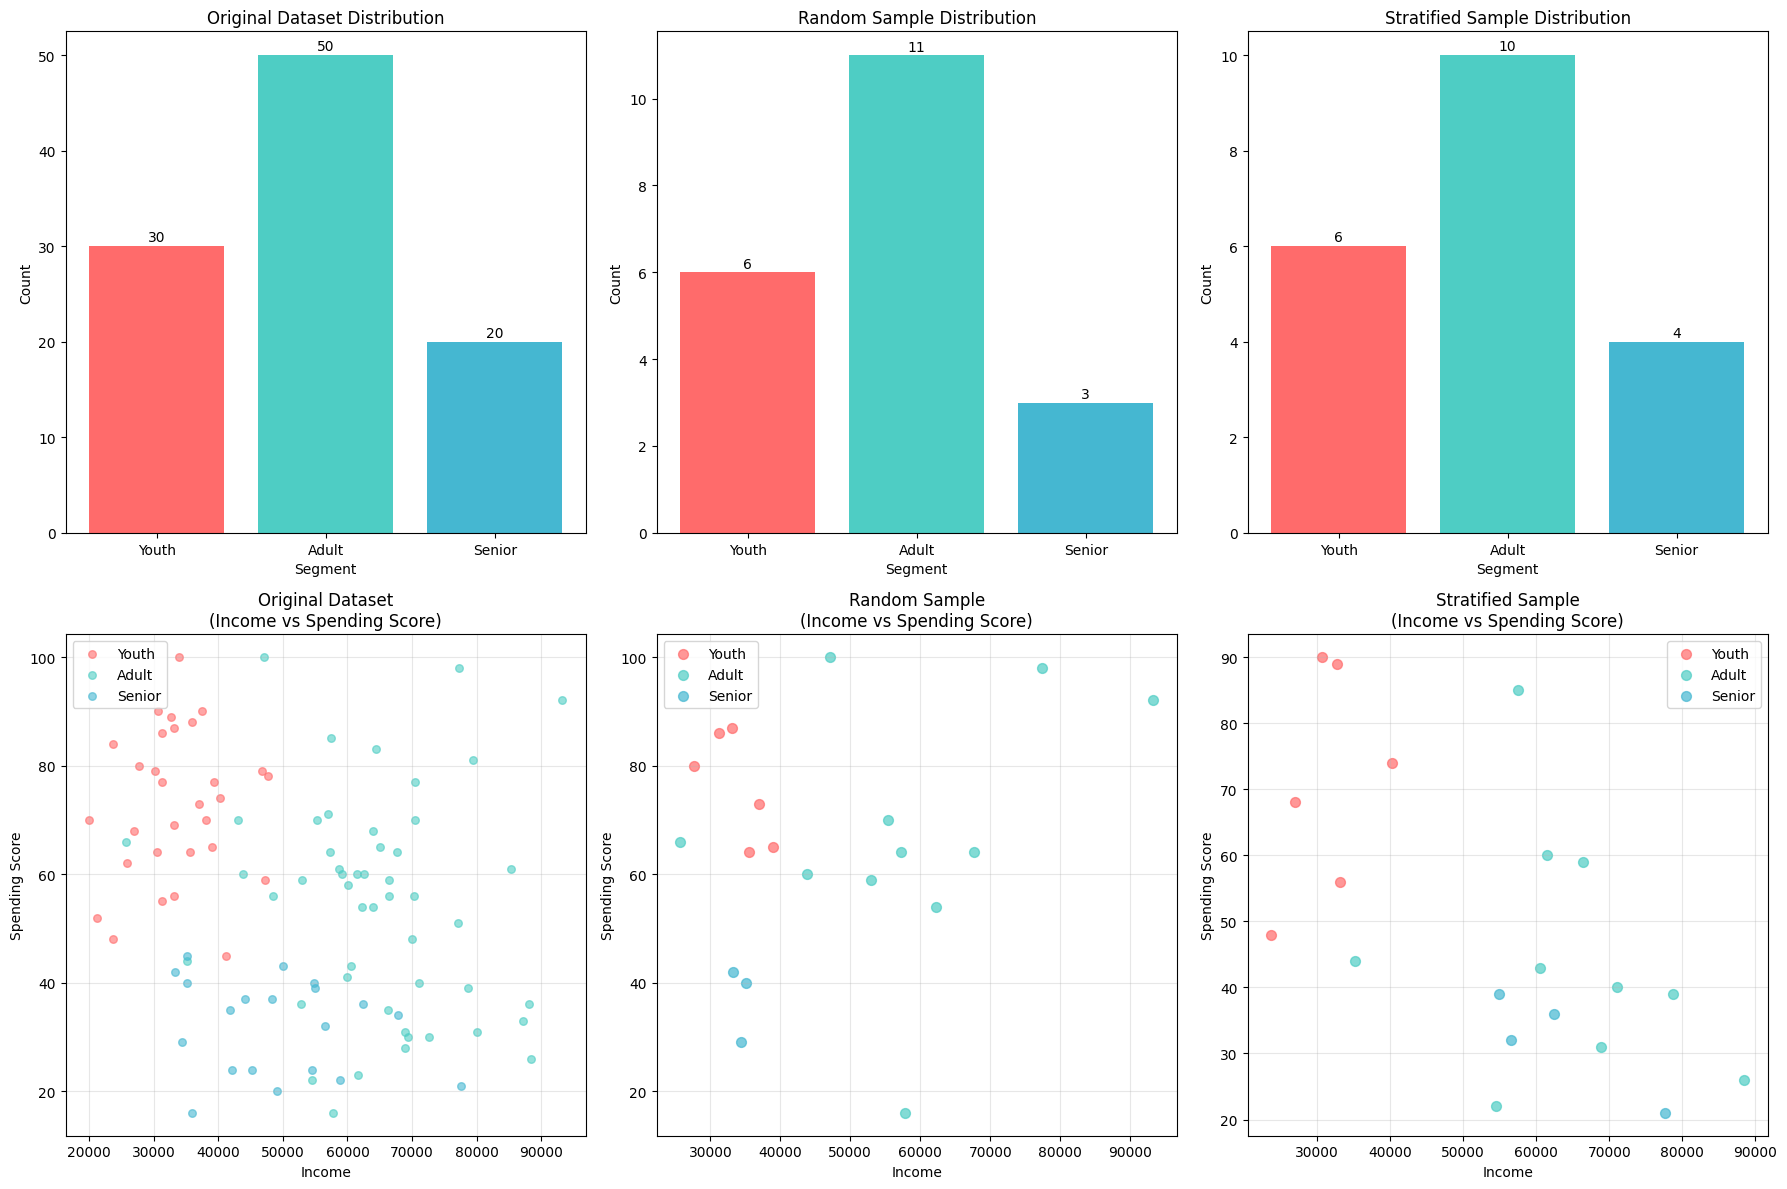

In [6]:
# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Distribution comparisons
segments = df['Segment'].unique()
x_pos = np.arange(len(segments))

# Original distribution
original_counts = [len(df[df['Segment'] == seg]) for seg in segments]
axes[0, 0].bar(x_pos, original_counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 0].set_title('Original Dataset Distribution')
axes[0, 0].set_xlabel('Segment')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(segments)
for i, count in enumerate(original_counts):
    axes[0, 0].text(i, count + 0.5, str(count), ha='center')

# Random sample distribution
random_counts = [len(random_sample[random_sample['Segment'] == seg]) for seg in segments]
axes[0, 1].bar(x_pos, random_counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 1].set_title('Random Sample Distribution')
axes[0, 1].set_xlabel('Segment')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(segments)
for i, count in enumerate(random_counts):
    axes[0, 1].text(i, count + 0.1, str(count), ha='center')

# Stratified sample distribution
stratified_counts = [len(stratified_sample[stratified_sample['Segment'] == seg]) for seg in segments]
axes[0, 2].bar(x_pos, stratified_counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 2].set_title('Stratified Sample Distribution')
axes[0, 2].set_xlabel('Segment')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_xticks(x_pos)
axes[0, 2].set_xticklabels(segments)
for i, count in enumerate(stratified_counts):
    axes[0, 2].text(i, count + 0.1, str(count), ha='center')

# Row 2: Scatter plots
colors = {'Youth': '#FF6B6B', 'Adult': '#4ECDC4', 'Senior': '#45B7D1'}

# Original data scatter plot
for segment in segments:
    segment_data = df[df['Segment'] == segment]
    axes[1, 0].scatter(segment_data['Income'], segment_data['Spending_Score'], 
                      label=segment, alpha=0.6, color=colors[segment], s=30)
axes[1, 0].set_title('Original Dataset\n(Income vs Spending Score)')
axes[1, 0].set_xlabel('Income')
axes[1, 0].set_ylabel('Spending Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Random sample scatter plot
for segment in segments:
    segment_data = random_sample[random_sample['Segment'] == segment]
    axes[1, 1].scatter(segment_data['Income'], segment_data['Spending_Score'], 
                      label=segment, alpha=0.7, color=colors[segment], s=50)
axes[1, 1].set_title('Random Sample\n(Income vs Spending Score)')
axes[1, 1].set_xlabel('Income')
axes[1, 1].set_ylabel('Spending Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Stratified sample scatter plot
for segment in segments:
    segment_data = stratified_sample[stratified_sample['Segment'] == segment]
    axes[1, 2].scatter(segment_data['Income'], segment_data['Spending_Score'], 
                      label=segment, alpha=0.7, color=colors[segment], s=50)
axes[1, 2].set_title('Stratified Sample\n(Income vs Spending Score)')
axes[1, 2].set_xlabel('Income')
axes[1, 2].set_ylabel('Spending Score')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6: Statistical Validation

Let's compare how well each sampling method preserves the statistical properties of each segment.

In [7]:
def compare_segment_statistics(original_df, sample_df, sample_name):
    """Compare statistical properties between original and sample data by segment"""
    
    print(f"\n{sample_name} - Statistical Comparison by Segment:")
    print("=" * 60)
    
    for segment in original_df['Segment'].unique():
        print(f"\n{segment} Segment:")
        
        # Original segment data
        orig_seg = original_df[original_df['Segment'] == segment]
        
        # Sample segment data
        samp_seg = sample_df[sample_df['Segment'] == segment]
        
        if len(samp_seg) == 0:
            print(f"  WARNING: No {segment} customers in sample!")
            continue
            
        # Income comparison
        orig_income_mean = orig_seg['Income'].mean()
        samp_income_mean = samp_seg['Income'].mean()
        income_diff_pct = abs(orig_income_mean - samp_income_mean) / orig_income_mean * 100
        
        # Spending score comparison
        orig_score_mean = orig_seg['Spending_Score'].mean()
        samp_score_mean = samp_seg['Spending_Score'].mean()
        score_diff_pct = abs(orig_score_mean - samp_score_mean) / orig_score_mean * 100
        
        print(f"  Sample size: {len(samp_seg)}/{len(orig_seg)} ({len(samp_seg)/len(orig_seg)*100:.1f}%)")
        print(f"  Income - Original: ${orig_income_mean:.0f}, Sample: ${samp_income_mean:.0f}, Diff: {income_diff_pct:.1f}%")
        print(f"  Score  - Original: {orig_score_mean:.1f}, Sample: {samp_score_mean:.1f}, Diff: {score_diff_pct:.1f}%")

# Compare both sampling methods
compare_segment_statistics(df, random_sample, "RANDOM SAMPLING")
compare_segment_statistics(df, stratified_sample, "STRATIFIED SAMPLING")


RANDOM SAMPLING - Statistical Comparison by Segment:

Youth Segment:
  Sample size: 6/30 (20.0%)
  Income - Original: $33504, Sample: $33934, Diff: 1.3%
  Score  - Original: 72.6, Sample: 75.8, Diff: 4.5%

Adult Segment:
  Sample size: 11/50 (22.0%)
  Income - Original: $64520, Sample: $58210, Diff: 9.8%
  Score  - Original: 54.4, Sample: 67.5, Diff: 24.1%

Senior Segment:
  Sample size: 3/20 (15.0%)
  Income - Original: $49098, Sample: $34260, Diff: 30.2%
  Score  - Original: 32.0, Sample: 37.0, Diff: 15.6%

STRATIFIED SAMPLING - Statistical Comparison by Segment:

Youth Segment:
  Sample size: 6/30 (20.0%)
  Income - Original: $33504, Sample: $31202, Diff: 6.9%
  Score  - Original: 72.6, Sample: 70.8, Diff: 2.4%

Adult Segment:
  Sample size: 10/50 (20.0%)
  Income - Original: $64520, Sample: $64270, Diff: 0.4%
  Score  - Original: 54.4, Sample: 44.9, Diff: 17.5%

Senior Segment:
  Sample size: 4/20 (20.0%)
  Income - Original: $49098, Sample: $62892, Diff: 28.1%
  Score  - Original

## Step 7: Advanced Stratified Sampling Techniques

Let's explore more sophisticated stratified sampling approaches for different scenarios.

In [8]:
# Technique 1: Proportional Stratified Sampling with custom sample sizes
def proportional_stratified_sampling(data, strata_column, total_sample_size, random_state=42):
    """
    Perform proportional stratified sampling where sample size from each stratum
    is proportional to the stratum size in the population
    """
    
    samples = []
    
    for stratum in data[strata_column].unique():
        stratum_data = data[data[strata_column] == stratum]
        stratum_proportion = len(stratum_data) / len(data)
        stratum_sample_size = int(stratum_proportion * total_sample_size)
        
        if stratum_sample_size > 0:
            stratum_sample = stratum_data.sample(n=stratum_sample_size, random_state=random_state)
            samples.append(stratum_sample)
            
    return pd.concat(samples, ignore_index=True)

# Apply proportional stratified sampling
prop_sample = proportional_stratified_sampling(df, 'Segment', 25)
print("Proportional Stratified Sampling (25 customers):")
print(prop_sample['Segment'].value_counts())

# Technique 2: Equal Allocation Stratified Sampling
def equal_allocation_sampling(data, strata_column, samples_per_stratum, random_state=42):
    """
    Sample equal number of observations from each stratum
    """
    
    samples = []
    
    for stratum in data[strata_column].unique():
        stratum_data = data[data[strata_column] == stratum]
        
        # Sample the minimum of requested size or available data
        sample_size = min(samples_per_stratum, len(stratum_data))
        stratum_sample = stratum_data.sample(n=sample_size, random_state=random_state)
        samples.append(stratum_sample)
        
    return pd.concat(samples, ignore_index=True)

# Apply equal allocation sampling
equal_sample = equal_allocation_sampling(df, 'Segment', 8)
print(f"\nEqual Allocation Sampling (8 per segment):")
print(equal_sample['Segment'].value_counts())

# Technique 3: Optimal Allocation (Neyman allocation)
def optimal_allocation_sampling(data, strata_column, variable_column, total_sample_size, random_state=42):
    """
    Optimal allocation based on standard deviation of the variable of interest
    More samples from strata with higher variance
    """
    
    # Calculate standard deviation for each stratum
    strata_stats = data.groupby(strata_column)[variable_column].agg(['std', 'count']).fillna(0)
    
    # Calculate optimal allocation
    total_std_pop = (strata_stats['std'] * strata_stats['count']).sum()
    
    samples = []
    
    for stratum in data[strata_column].unique():
        stratum_data = data[data[strata_column] == stratum]
        stratum_std = strata_stats.loc[stratum, 'std']
        stratum_pop = strata_stats.loc[stratum, 'count']
        
        # Optimal sample size for this stratum
        optimal_size = int((stratum_std * stratum_pop / total_std_pop) * total_sample_size)
        optimal_size = max(1, min(optimal_size, len(stratum_data)))  # Ensure valid size
        
        stratum_sample = stratum_data.sample(n=optimal_size, random_state=random_state)
        samples.append(stratum_sample)
        
    return pd.concat(samples, ignore_index=True)

# Apply optimal allocation based on Income variance
optimal_sample = optimal_allocation_sampling(df, 'Segment', 'Income', 25)
print(f"\nOptimal Allocation Sampling based on Income variance (25 total):")
print(optimal_sample['Segment'].value_counts())

Proportional Stratified Sampling (25 customers):
Segment
Adult     12
Youth      7
Senior     5
Name: count, dtype: int64

Equal Allocation Sampling (8 per segment):
Segment
Youth     8
Adult     8
Senior    8
Name: count, dtype: int64

Optimal Allocation Sampling based on Income variance (25 total):
Segment
Adult     14
Senior     5
Youth      4
Name: count, dtype: int64


## Step 8: Practical Applications and Use Cases

Let's demonstrate real-world scenarios where stratified sampling is particularly valuable.

In [9]:
# Application 1: Machine Learning with Balanced Training Sets
def create_balanced_train_test_split(data, target_column, test_size=0.2, random_state=42):
    """Create balanced train-test splits ensuring each class is represented"""
    
    X = data.drop(columns=[target_column])
    y = data[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

# Create balanced splits for ML
X_train, X_test, y_train, y_test = create_balanced_train_test_split(df, 'Segment')

print("Machine Learning Train-Test Split Results:")
print(f"Training set: {len(X_train)} samples")
print("Training set distribution:")
print(y_train.value_counts())
print(f"\nTest set: {len(X_test)} samples") 
print("Test set distribution:")
print(y_test.value_counts())

# Application 2: Survey Sampling
def survey_stratified_sampling(data, strata_column, confidence_level=0.95, margin_error=0.05):
    """
    Calculate required sample sizes for survey research with stratified sampling
    """
    
    from scipy import stats
    
    # Z-score for confidence level
    z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    
    print(f"Survey Sampling Requirements:")
    print(f"Confidence Level: {confidence_level*100}%")
    print(f"Margin of Error: {margin_error*100}%")
    print(f"Z-score: {z_score:.2f}")
    
    total_required = 0
    
    for stratum in data[strata_column].unique():
        stratum_data = data[data[strata_column] == stratum]
        N = len(stratum_data)  # Population size for stratum
        
        # Assume maximum variance (p=0.5) for conservative estimate
        p = 0.5
        
        # Sample size calculation for finite population
        n = (z_score**2 * p * (1-p)) / (margin_error**2)
        n_adjusted = n / (1 + (n-1)/N)  # Finite population correction
        
        required_sample = int(np.ceil(n_adjusted))
        total_required += required_sample
        
        print(f"\n{stratum} Segment:")
        print(f"  Population size: {N}")
        print(f"  Required sample: {required_sample}")
        print(f"  Sampling fraction: {required_sample/N*100:.1f}%")
    
    print(f"\nTotal required sample size: {total_required}")
    return total_required

# Calculate survey requirements
survey_sample_size = survey_stratified_sampling(df, 'Segment')

Machine Learning Train-Test Split Results:
Training set: 80 samples
Training set distribution:
Segment
Adult     40
Youth     24
Senior    16
Name: count, dtype: int64

Test set: 20 samples
Test set distribution:
Segment
Adult     10
Youth      6
Senior     4
Name: count, dtype: int64
Survey Sampling Requirements:
Confidence Level: 95.0%
Margin of Error: 5.0%
Z-score: 1.96

Youth Segment:
  Population size: 30
  Required sample: 28
  Sampling fraction: 93.3%

Adult Segment:
  Population size: 50
  Required sample: 45
  Sampling fraction: 90.0%

Senior Segment:
  Population size: 20
  Required sample: 20
  Sampling fraction: 100.0%

Total required sample size: 93


## Step 9: Quality Assessment and Validation

Let's develop comprehensive methods to assess the quality of our stratified sampling.

In [10]:
def comprehensive_sampling_assessment(original_data, sample_data, strata_column):
    """
    Comprehensive assessment of stratified sampling quality
    """
    
    print("COMPREHENSIVE SAMPLING QUALITY ASSESSMENT")
    print("=" * 60)
    
    # 1. Representativeness Assessment
    print("\n1. REPRESENTATIVENESS ASSESSMENT:")
    print("-" * 40)
    
    for stratum in original_data[strata_column].unique():
        orig_count = len(original_data[original_data[strata_column] == stratum])
        samp_count = len(sample_data[sample_data[strata_column] == stratum])
        
        orig_pct = orig_count / len(original_data) * 100
        samp_pct = samp_count / len(sample_data) * 100
        
        difference = abs(orig_pct - samp_pct)
        
        # Quality rating
        if difference < 1:
            quality = "Excellent"
        elif difference < 3:
            quality = "Good"  
        elif difference < 5:
            quality = "Fair"
        else:
            quality = "Poor"
            
        print(f"{stratum}: {orig_pct:.1f}% → {samp_pct:.1f}% (Δ{difference:.1f}%) - {quality}")
    
    # 2. Statistical Properties Assessment
    print(f"\n2. STATISTICAL PROPERTIES ASSESSMENT:")
    print("-" * 40)
    
    numeric_columns = original_data.select_dtypes(include=[np.number]).columns
    numeric_columns = [col for col in numeric_columns if col != 'Customer_ID']
    
    for col in numeric_columns:
        orig_mean = original_data[col].mean()
        samp_mean = sample_data[col].mean()
        
        orig_std = original_data[col].std()
        samp_std = sample_data[col].std()
        
        mean_diff_pct = abs(orig_mean - samp_mean) / orig_mean * 100
        std_diff_pct = abs(orig_std - samp_std) / orig_std * 100
        
        print(f"{col}:")
        print(f"  Mean: {orig_mean:.1f} → {samp_mean:.1f} (Δ{mean_diff_pct:.1f}%)")
        print(f"  Std:  {orig_std:.1f} → {samp_std:.1f} (Δ{std_diff_pct:.1f}%)")
    
    # 3. Coverage Assessment
    print(f"\n3. COVERAGE ASSESSMENT:")
    print("-" * 40)
    
    missing_strata = set(original_data[strata_column].unique()) - set(sample_data[strata_column].unique())
    if missing_strata:
        print(f"Missing strata in sample: {missing_strata}")
    else:
        print("All strata represented in sample ✓")
    
    # 4. Sample Efficiency
    print(f"\n4. SAMPLE EFFICIENCY:")
    print("-" * 40)
    
    sampling_fraction = len(sample_data) / len(original_data) * 100
    print(f"Sampling fraction: {sampling_fraction:.1f}%")
    print(f"Sample size: {len(sample_data)}/{len(original_data)}")
    
    if sampling_fraction < 5:
        efficiency = "Very High"
    elif sampling_fraction < 15:
        efficiency = "High"
    elif sampling_fraction < 30:
        efficiency = "Moderate" 
    else:
        efficiency = "Low"
        
    print(f"Efficiency rating: {efficiency}")

# Assess our stratified sample
comprehensive_sampling_assessment(df, stratified_sample, 'Segment')

# Compare with random sample
print(f"\n" + "="*80)
print("COMPARISON: Random Sample Assessment")
print("="*80)
comprehensive_sampling_assessment(df, random_sample, 'Segment')

COMPREHENSIVE SAMPLING QUALITY ASSESSMENT

1. REPRESENTATIVENESS ASSESSMENT:
----------------------------------------
Youth: 30.0% → 30.0% (Δ0.0%) - Excellent
Adult: 50.0% → 50.0% (Δ0.0%) - Excellent
Senior: 20.0% → 20.0% (Δ0.0%) - Excellent

2. STATISTICAL PROPERTIES ASSESSMENT:
----------------------------------------
Income:
  Mean: 52130.7 → 54074.3 (Δ3.7%)
  Std:  17801.6 → 18986.0 (Δ6.7%)
Spending_Score:
  Mean: 55.4 → 50.1 (Δ9.6%)
  Std:  21.8 → 21.7 (Δ0.1%)

3. COVERAGE ASSESSMENT:
----------------------------------------
All strata represented in sample ✓

4. SAMPLE EFFICIENCY:
----------------------------------------
Sampling fraction: 20.0%
Sample size: 20/100
Efficiency rating: Moderate

COMPARISON: Random Sample Assessment
COMPREHENSIVE SAMPLING QUALITY ASSESSMENT

1. REPRESENTATIVENESS ASSESSMENT:
----------------------------------------
Youth: 30.0% → 30.0% (Δ0.0%) - Excellent
Adult: 50.0% → 55.0% (Δ5.0%) - Poor
Senior: 20.0% → 15.0% (Δ5.0%) - Poor

2. STATISTICAL PROPER

## Key Takeaways and Summary

### What We've Learned:

1. **Stratified Sampling Definition**: A probability sampling method that divides the population into homogeneous subgroups (strata) and samples from each stratum proportionally.

2. **Key Advantages over Simple Random Sampling**:
   - **Guaranteed representation** of all important subgroups
   - **Reduced sampling variance** for population estimates
   - **Better precision** with smaller sample sizes
   - **More reliable insights** for heterogeneous populations

3. **Types of Stratified Sampling**:
   - **Proportional**: Sample size from each stratum proportional to stratum size
   - **Equal Allocation**: Same number of samples from each stratum
   - **Optimal Allocation**: Sample sizes based on stratum variance (Neyman allocation)

4. **Implementation with Scikit-learn**: Using `train_test_split` with the `stratify` parameter ensures proportional representation.

### When to Use Stratified Sampling:

- **Heterogeneous populations** with distinct subgroups
- **Machine learning** projects requiring balanced datasets
- **Survey research** ensuring representation of minority groups
- **Market research** across different customer segments
- **Medical studies** with different patient populations
- **A/B testing** with user segmentation

### Advantages:
- ✅ Guarantees representation of all strata
- ✅ Reduces sampling error and variance
- ✅ More precise estimates for subgroups
- ✅ Better statistical power for comparisons
- ✅ Eliminates risk of missing important segments

### Limitations:
- ❌ Requires knowledge of population strata
- ❌ More complex than simple random sampling
- ❌ May need larger total sample sizes
- ❌ Strata boundaries must be clearly defined
- ❌ Less efficient for homogeneous populations

### Best Practices:
1. **Define strata carefully** based on relevant characteristics
2. **Ensure strata are homogeneous** within and heterogeneous between
3. **Use proportional allocation** unless specific requirements dictate otherwise
4. **Validate sample quality** by comparing distributions and statistics
5. **Document stratification variables** for reproducibility
6. **Consider optimal allocation** when variance differs significantly between strata
7. **Monitor minimum sample sizes** per stratum for statistical validity

### Real-World Applications:
- **E-commerce**: Sampling across customer segments (new, regular, premium)
- **Healthcare**: Patient studies across age groups, conditions, or demographics  
- **Finance**: Risk assessment across different investment portfolios
- **Education**: Student performance across different schools or programs
- **Marketing**: Campaign effectiveness across different target audiences

This notebook demonstrated how stratified sampling ensures representative samples from heterogeneous populations, making it an essential technique for robust data mining and statistical analysis.